In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)
library(phyloseq)
library(RColorBrewer)
library(gridExtra)
library(DESeq2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.uns

In [4]:
%%R
asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)

physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","12CCSS","13CCSS", "13CXPS"))& 
                            (physeq.md$Day %in% c(30)) &
                            row.names(physeq.md) %in% grep("bulk", 
                                                          row.names(physeq.md), 
                                                          value=TRUE), physeq)

physeq.bulk = filter_taxa(physeq.bulk, function(x) sum(x) > 0, prune = TRUE)

print(physeq.bulk)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2192 taxa and 5 samples ]
sample_data() Sample Data:       [ 5 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 2192 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2192 tips and 2191 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]


In [5]:
%%R
md = sample_data(physeq.bulk)
md$amendment = factor(ifelse(md$Treatment %in% c("13CCSS", "12CCSS"), 
                             "Cellulose Only", 
                             "Complex C Mixture"),
                      levels = c("Complex C Mixture", "Cellulose Only"))
sample_data(physeq.bulk) = md

In [6]:
%%R
colnames(sample_data(physeq.bulk))

[1] "X.SampleID"           "BarcodeSequence"      "Day"                 
[4] "Density"              "LinkerPrimerSequence" "Treatment"           
[7] "Description"          "amendment"           


In [7]:
%%R
dds = phyloseq_to_deseq2(physeq.bulk, ~amendment)
dds = DESeq(dds, fitType = "local")

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [8]:
%%R
df.bulk = data.frame(results(dds, independentFiltering = FALSE)) %>%
    select(l2fc.bulk = log2FoldChange)
df.bulk$OTU = rownames(df.bulk)
head(df.bulk)

          l2fc.bulk      OTU
OTU.3574  1.3682291 OTU.3574
OTU.4213  1.3745700 OTU.4213
OTU.4547  1.3745700 OTU.4547
OTU.916   1.0311061  OTU.916
OTU.2638 -0.4339465 OTU.2638
OTU.79    0.2102832   OTU.79


Joining by: "OTU"


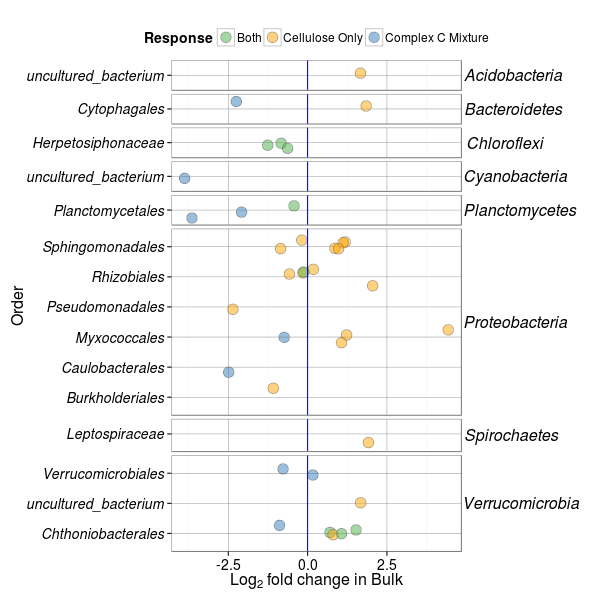

In [9]:
%%R -h 600 -w 600
FDR = 0.10

rspnse = function(x, t) {
    ifelse(length(x) == 2, "Both", ifelse(t == "13CCSS", 
                                          "Cellulose Only", 
                                          "Complex C Mixture"))
}

df.rspnse = read.csv("data/l2fc_table.csv") %>%
    group_by(OTU, Treatment) %>%
    summarize(min.P = min(padj), 
              Rank2 = first(Rank2), 
              Rank4 = first(Rank4)) %>%
    filter(min.P <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = rspnse(min.P, Treatment), 
              Rank2 = first(Rank2),
              Rank4 = first(Rank4)) %>%
    left_join(df.bulk)

colours = c("#4daf4a", "orange", "#377eb8")

p = ggplot(df.rspnse, aes(y = Rank4, x = l2fc.bulk, fill = rspnse))

p = p + geom_point(size = 5, shape = 21, alpha = 0.5, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p = p + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p = p + geom_vline(xintercept = 0, color = "blue")

p = p + scale_fill_manual(values = colours, na.value = "black")

p = p + theme_bw()

p = p + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = "Order", fill = "Response")

p = p + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p.fc = p

p

In [17]:
%%R
ggsave("figs/l2fc.bulk_dotplotby_phylum.pdf", p.fc, h = 10, w = 8)

In [18]:
FileLink("figs/l2fc.bulk_dotplotby_phylum.pdf")

/home/ashley/single_substrate/figs/l2fc.bulk_dotplotby_phylum.pdf

In [19]:
%%R
ggsave("figs/l2fc.bulk_dotplotby_phylum.png", p.fc, h = 10, w = 8)

In [20]:
FileLink("figs/l2fc.bulk_dotplotby_phylum.png")

/home/ashley/single_substrate/figs/l2fc.bulk_dotplotby_phylum.png